# Code demonstration for the annotated MIND module
author @ Quentin RV. Ferry

This demonstration notebook cover the following:
- The Creation of synthetic data to demo MIND on.
- "Fiting" a MIND model to the data. That is embedding the data into a lower-dimensional space that reflects the dynamics of the system.
- Learning a locally linear embedding (LLE) mapping from the state space to embedding space (i.e., forward transform) and project new states onto the manifold.
- Learning a LLE mapping from the embedding space to the state space (i.e., reverse transform) and infer state space coordinates for point of interests chosen on the manifold.

The annotated MIND module is an implementation of the "manifold inference from neural dynamics" method reported in:

> [Low, R. J., Lewallen, S., Aronov, D., Nevers, R. & Tank, D. W. 
Probing variability in a cognitive map using manifold inference from neural dynamics. 
Biorxiv 418939 (2018) doi:10.1101/418939.](https://www.biorxiv.org/content/10.1101/418939v2)

---
# Imports
See import section in **mind.py** for additional Python modules requirements.

In [1]:
# for everything linear algebra
import numpy as np

# to create our synthetic dataset
from sklearn import datasets
from sklearn.neighbors import NearestNeighbors

# to create MIND embeddings
from mind import MIND

# For plotting purposes
import matplotlib.pyplot as plt
%matplotlib inline

---
# Generating synthetic data
MIND was created to generate low-dimensional embeddings of dynamical neural data (think [eletrophysiology](https://en.wikipedia.org/wiki/Electrophysiology) or [calcium imaging](https://en.wikipedia.org/wiki/Calcium_imaging)). The hope is that the method might reveal low-dimensional **manifolds** along which neural activity is thought to be constrained. However, and in the interest of time, we won't be running this demo on neural data. Instead, we will make up our very own synthetic data, which has the following two advantages: (i) By choosing a smaller size for our dataset we can reduce the amount of computations, speed up the process, and make sure this demo can run on anyone's laptop; (ii) By constructing our high-dimensional data so that we know that all points are constrained to a lower-dimensional manifold of our choosing, we have a benchmark to test the performance of our MIND implementation.

We choose our state space to be 3-dimensional and our states (matrix $X$, such that each row corresponds to a state $x$) to fall on a 2-dimensional [Swiss roll manifold](https://scikit-learn.org/stable/auto_examples/manifold/plot_swissroll.html) (this is a classic for testing unsupervised learning algorithms). Now, in addition to our states $X$, MIND needs to know the dynamics of our system. To that end, we provide the matrix $Xp$ (for prime), with the same dimensions as $X$, that contains a matching successor state $x'$ for each $x$. 

If $x'$ is a successor state of $x$, then the transition probability $P(x'|x)$ should be high, and the two states should fall close to each other in the MIND embedding (i.e. the Euclidian distance between their respective projections $y'$ and $y$ should be small). In the contrary, if $x'$ and $x$ are not part of the same *dynamical sequence*, then $P(x'|x)$ should be smaller, and this difference should be reflected by a greater pairwise distance in the MIND embedding.

Taking this last point into consideration, if we want our MIND embedding to recover the 2D manifold off the original 3D state space, we need to choose our $x'$ such that they land on the manifold and in the vicinity off their corresponding $x$ (i.e., dynamics represent a random walk on the 2D manifold). To that end, we start by randomly sampling $N$ states on the Swiss roll to create $X$. For each $x$ in $X$ we then find the matching $x'$ by randomly picking one of $x$'s K nearest neighbors amongst $X$.    

In [2]:
# parameters
param_N = 5000 # number of states    
param_K = 10 # number of nearest neighbors to consider when choosing x'
param_manifold_noise = .5 # noise around the manifold
#///////////////////////////////////////////

# generate X
X, t = datasets.make_swiss_roll(n_samples = param_N, noise = param_manifold_noise)
X = X[np.argsort(t)] # sort all x by their position along the roll

# make Xp by choosing a close neighbor of x_i
knn = NearestNeighbors(n_neighbors= param_K+1, algorithm='kd_tree').fit(X)
distances, indices = knn.kneighbors(X)
indices = indices[:,1:] # remove self
Xp = np.zeros(X.shape)
for i in range(X.shape[0]):
    Xp[i,:] = X[np.random.choice(indices[i,:],1),:]

Let's have a look at our synthetic data:

<IPython.core.display.Javascript object>


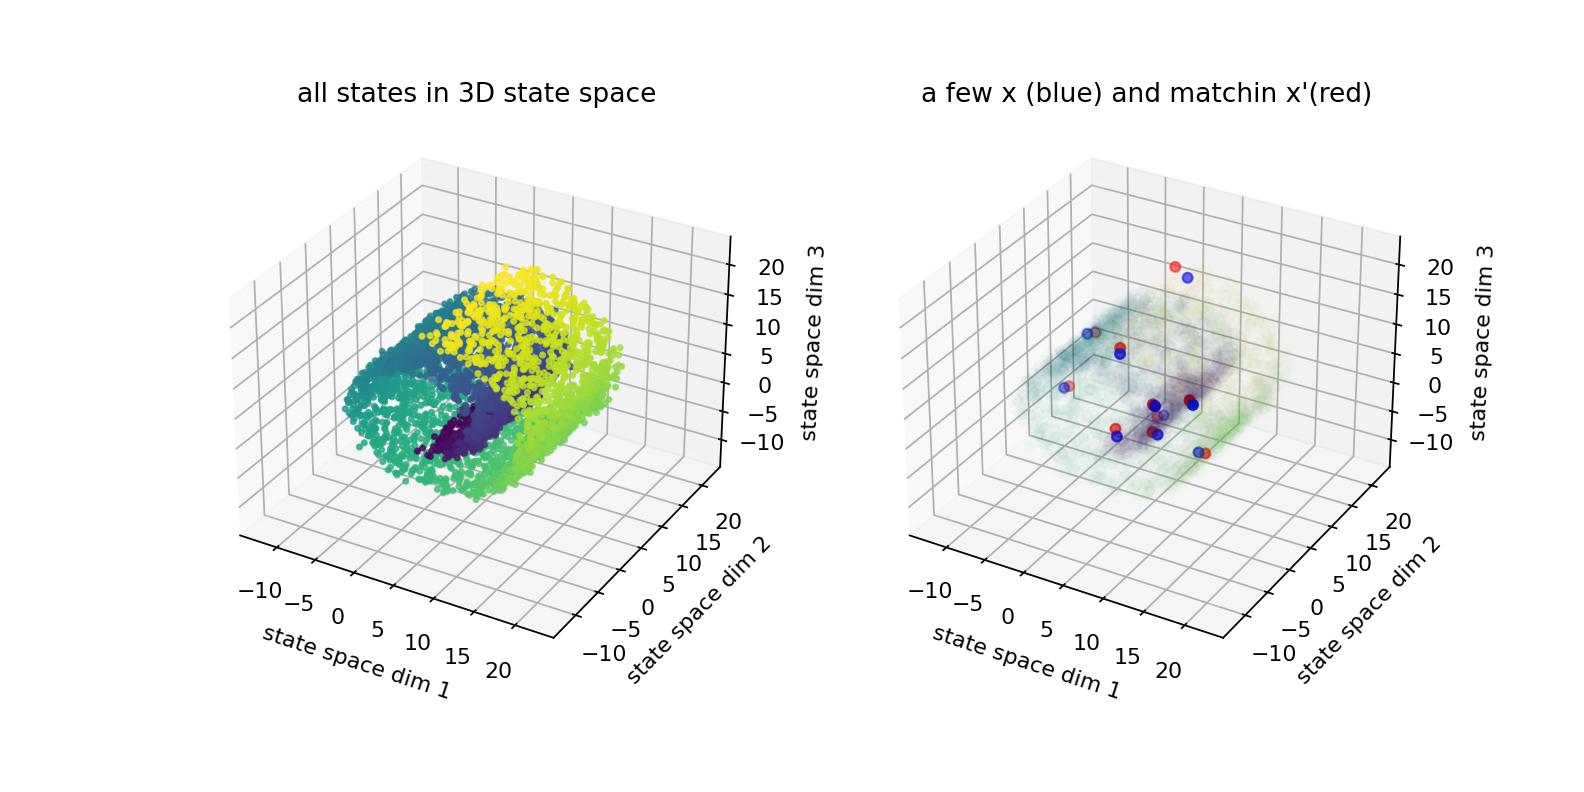

In [4]:
# define a bounding box to force 'aspect = equal' in 3D plots
min_dim = X.max()
max_dim = X.min()
bb = np.meshgrid(np.array([min_dim,max_dim]), 
                   np.array([min_dim,max_dim]), 
                   np.array([min_dim,max_dim]))


%matplotlib notebook
fig = plt.figure(figsize=(10, 5))

# display all data
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter3D(bb[0].flatten(), bb[1].flatten(), bb[2].flatten(), 
             c = 'white', alpha = 0.1)
ax.scatter3D(X[:,0], X[:,1], X[:,2], 
             s = 5, c = np.arange(X.shape[0]), cmap = 'viridis', alpha = 0.75)
ax.set_title('all states in 3D state space')
ax.set_xlabel('state space dim 1')
ax.set_ylabel('state space dim 2')
ax.set_zlabel('state space dim 3')
#---------------------------------------------------------------

# display 10 randomly chosen x in blue and their corresponding x' in red
sources = np.linspace(0, param_N-1, 10).astype('int')
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter3D(bb[0].flatten(), bb[1].flatten(), bb[2].flatten(), 
             c = 'white', alpha = 0.1)
ax.scatter3D(X[:,0], X[:,1], X[:,2], c = np.arange(X.shape[0]), 
             cmap = 'viridis', alpha = 0.01)
ax.scatter3D(X[sources,0], X[sources,1], X[sources,2], c = 'red')
ax.scatter3D(Xp[sources,0], Xp[sources,1], Xp[sources,2], c = 'blue')
ax.set_title("a few x (blue) and matchin x'(red)")
ax.set_xlabel('state space dim 1')
ax.set_ylabel('state space dim 2')
ax.set_zlabel('state space dim 3')

plt.show()

---
# Fit MIND embedding to the data

Now that we have our 3D synthetic states nicely constrained to a convoluted 2D manifold, let's try to use the MIND algorithm to recover the manifold. To that end, we will be using an instance of the MIND class provided by our *mind.py* module. 

In short the MIND algorithm implements the following steps to construct the low-dimensional embedding:
- Fit a random forest to the data. The forest is composed of **nb_trees** trees that each parition the state space in a series of local neighborhoods (leaf nodes) organized in a hierarchy. Paritions are created recursively by speudo randomly spliting smaller and smaller regions of the state space ($X$ -> $X_{left}$ and $X_{right}$) using a hyperplane parametrised by a vector $v$ and corresponding intercept $c$. $v$ and $c$ are selected out of a random set of $\{v_i\}_i$ (cardinality **nb_v**) and $\{c_i\}_i$ (cardinality **nb_c**) to maximize the log likelihood of probabilistic pca models fitted to the sucessors of each halves ($Xp_{left}$ and $Xp_{right}$). Splitting stops when current node contains less than $2*$**nb_leaf**.   
- Use the MIND random forest and a shortest path algorithm to computes global distances between state pairs. Given two states $x_1$ and $x_2$, $P_i(x_2 | leaf_i(x_1))$ and $P_i(x_1 | leaf_i(x_2))$ are estimated using the generative model provided by each tree in the forest ($i$ indexes the tree). Consensus probabilities are obtained by taking the median off all non-zero probabilities across tree estimates and converted into local distances. In order to increase the sparsity of the local distance matrix, we have added the following two steps to the original MIND algorithm: (i) We zero out any conditional probability that falls below a user defined **p_threshold**. (ii)We require that at least k of **nb_trees** probability estimates be non-zero to return a consensus median probability. The fraction k/**nb_trees** is given by the **fraction_vote** variable and is user defined. Once a matrix of pairwise local distances is obtained, MIND uses [Dijkstra's shorted path algorithm](https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm) to estimate a global distance matrix $D$.
- Compute the projections of $X$ into a lower dimensional space ($Y$, dimensionality given by **emb_dim**) from $D$ using [mutidimensional scaling](https://en.wikipedia.org/wiki/Multidimensional_scaling). If **emb_mds_only** is set to False, MIND further optimizes the projection coordinates by gradient decent.
- Find the optimal LLE parameters to map novel data to the manifold and back.

<div class="alert alert-block alert-success">
For mode details on the parameters and algorithm, see our annotated module <em>mind.py</em>.
</div>
    
List of parameters:
- **param_forest_nb_trees**: number of tree in the MIND random forest
- **param_tree_nb_leaf**: min number of states in a node below which the node is considered a leaf and won't be split
- **param_tree_nb_v**: number of random candidates {v} (hyperplane vectors) for node partition
- **param_tree_nb_c**: number of random candidates {c} (intercepts) for node partition
- **param_emb_dim**: dimensionality of the embedding space.
- **param_emb_fraction**: fraction of all states (X) used to create the embedding (default = 1.)
- **param_emb_p_threshold**: min probability under which probability are considered equal to 0.
- **param_emb_fraction_vote**: min fraction of non-zero probaiblities across trees for p(x2|x2) to not be considered null (see explanation above). default value = 0.5.
- **param_emb_mds_only**: boolean indicating whether restricting the calculation of the coordinate to multidimensional scaling (default). if False, additional gradient-based optimization is performed.

In [5]:
# parameters
param_forest_nb_trees = 50
param_tree_nb_leaf = 50
param_tree_nb_v = 3
param_tree_nb_c = 9

param_emb_dim = 2
param_emb_fraction = 0.2
param_emb_p_threshold = 1e-10
param_emb_fraction_vote = 0.65
param_emb_mds_only = False
#///////////////////////////////////////////

# create a MIND object with nb_trees trees
#  and tree parition parameters nb_leaf, nb_v, and nb_c.
mind = MIND(nb_trees = param_forest_nb_trees,
            nb_leaf = param_tree_nb_leaf,
            nb_v = param_tree_nb_v,
            nb_c = param_tree_nb_c)

# fit MIND object to our synthetic data.
mind.fit(X, Xp, 
         emb_dim = param_emb_dim, emb_fraction = param_emb_fraction, 
         p_threshold = param_emb_p_threshold, fraction_vote = param_emb_fraction_vote,
         mds_only = False)

>> Creating 50 partitions (i.e. trees) of the state space.
... training completed                                                  
>> Creating a 2D embedding from 3D data.
... using 20.0% of X (1000 states)
... computing D matrix completed.   
... computing MDS completed.
... improving coordinates with gradient-based optimization:
...... new loss is 89.54% of original loss.                                                  
... embedding completed in 28.5s
>> Optimizing LLE mapping parameters
... gridsearch over default [K]: [5, 10, 15, 20, 25, 30]
... gridsearch over default [alpha]: [0.0001, 0.001, 0.01, 0.1, 1.0]
... optimizing for state (x) -> embedding (y) forward mapping
... Tunning LLE parameters completed. Selected K = 5, alpha = 0.1
... optimizing for embedding (y) -> state (x) reverse mapping
... Tunning LLE parameters completed. Selected K = 10, alpha = 0.0001


Let's display our states in their original 3D state space (left) 
and in the MIND embedding (right): 

<IPython.core.display.Javascript object>


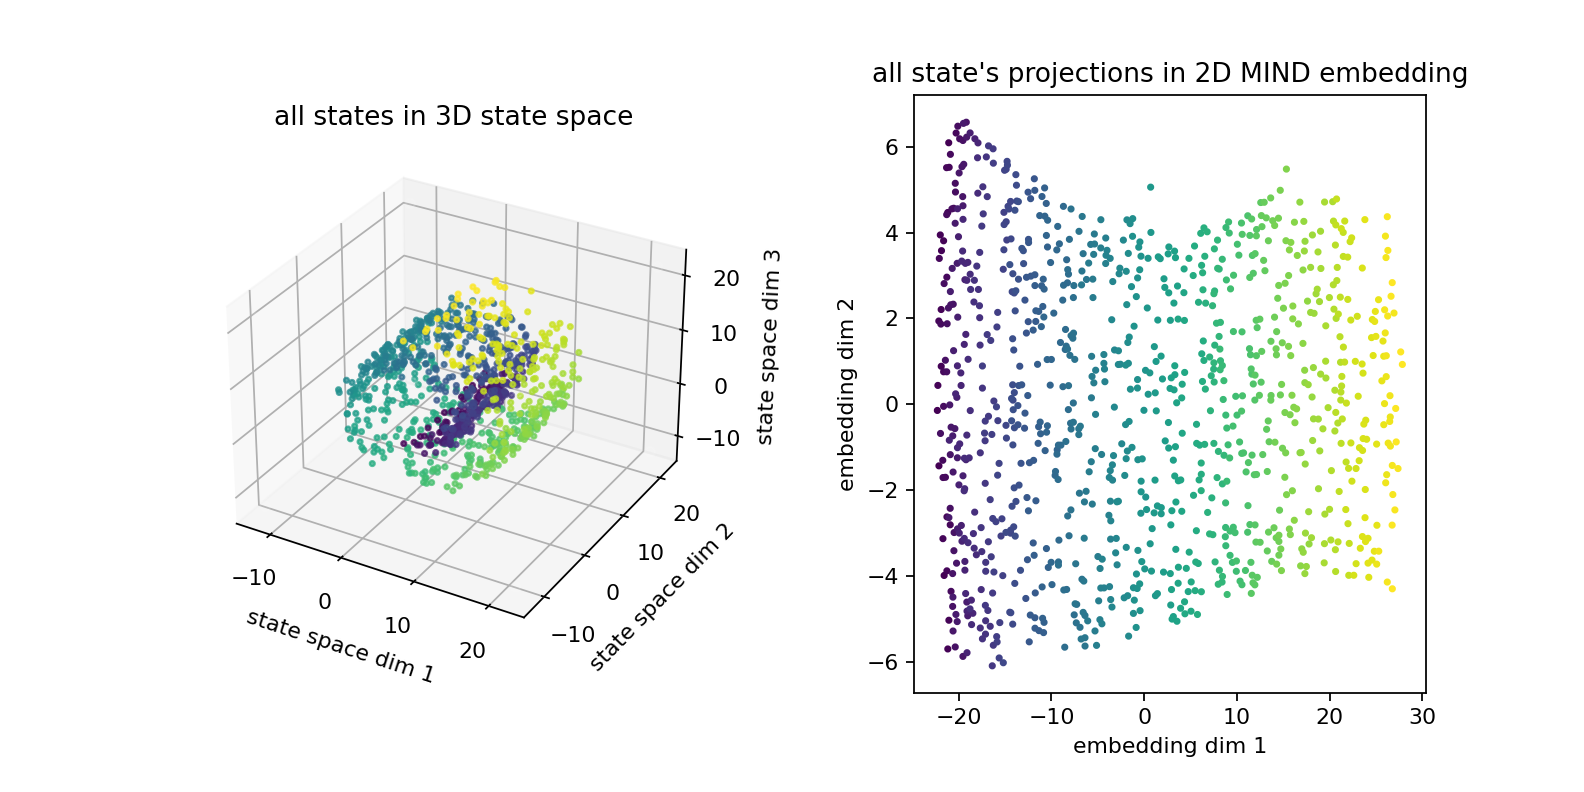

In [6]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 5))

# display data in the original 3D space
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter3D(bb[0].flatten(), bb[1].flatten(), bb[2].flatten(), 
             c = 'white', alpha = 0.1)
ax.scatter3D(mind.emb_X[:,0], mind.emb_X[:,1], mind.emb_X[:,2], 
             s = 5, c = np.arange(mind.emb_X.shape[0]), cmap = 'viridis', alpha = 0.75)
ax.set_title('all states in 3D state space')
ax.set_xlabel('state space dim 1')
ax.set_ylabel('state space dim 2')
ax.set_zlabel('state space dim 3')

# display data projected in the 2D MIND embedding
ax = fig.add_subplot(1, 2, 2)
ax.scatter(mind.emb_Y[:,0], mind.emb_Y[:,1], 
           s = 5, c = np.arange(mind.emb_Y.shape[0]))
ax.set_xlabel("embedding dim 1")
ax.set_ylabel("embedding dim 2")
ax.set_title("all state's projections in 2D MIND embedding")

plt.subplots_adjust(wspace=0.4)
plt.show()

---
# Forward and reverse transforms (from state space to embedding and back)

In the last step of the *fit* method, the module computes the optimal parameters for two LLE transforms: (i )The **foward transform** that project high-dimensional states onto the low-dimensional MIND embedding (i.e., $X$ to $Y$); (ii) The **reverse transform** that infers the full high-dimensional coordinates of a chosen point in the low-dimensional MIND embedding (i.e., $Y$ to $X$). Inline with *sklearn* syntax, both forward and reverse transforms can be computed using the *transform* and *reverse_transform* methods of a fitted mind instance.

In the example below, we generate **param_N2** new states in the state space ($Xq$, q stands for query), map them onto the MIND embedding ($Yq$), and then back ($Zq$). To make the process even more interesting we will choose $Xq$ so that the sequence of $xq_i$ forms a trajectory traversing the longitudinal axis of the manifold. 

<IPython.core.display.Javascript object>


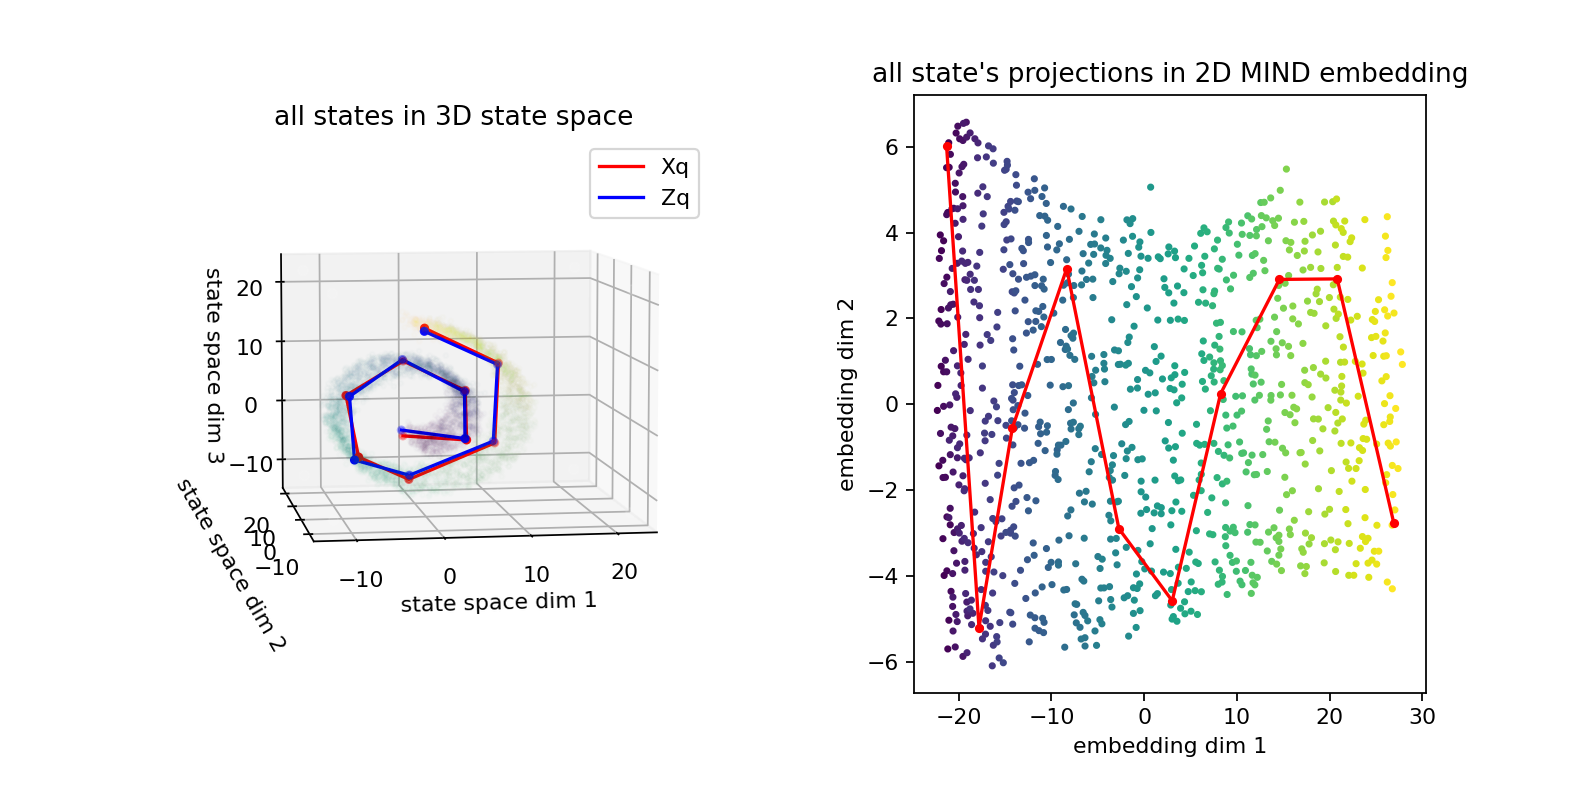

In [26]:
# parameters
param_N2 = 10
#///////////////////////////////////////////

# generate 1000 new states on the swiss roll 
Nb = 5000
Xb, t = datasets.make_swiss_roll(n_samples = Nb, noise = param_manifold_noise)
Xb = Xb[np.argsort(t)] # sort all x by their position along the roll

queries = np.linspace(0, Nb-1, param_N2).astype('int')
Xq = Xb[queries,:]

# map Xq to the MIND embedding
Yq = mind.transform(Xq)

# map Yq back to the state space
Zq = mind.reverse_transform(Yq)

%matplotlib notebook
fig = plt.figure(figsize=(10, 5))

# display trajectory in the original 3D space
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter3D(bb[0].flatten(), bb[1].flatten(), bb[2].flatten(), 
             c = 'white', alpha = 0.1)
ax.scatter3D(Xb[:,0], Xb[:,1], Xb[:,2], 
             s = 5, c = np.arange(Xb.shape[0]), cmap = 'viridis', alpha = 0.01)

ax.plot3D(Xq[:,0], Xq[:,1], Xq[:,2], c = 'red', label = 'Xq')
ax.scatter3D(Xq[:,0], Xq[:,1], Xq[:,2], 
             s = 10, c = 'red')

ax.plot3D(Zq[:,0], Zq[:,1], Zq[:,2], c = 'blue', label = 'Zq')
ax.scatter3D(Zq[:,0], Zq[:,1], Zq[:,2], 
             s = 10, c = 'blue')

ax.set_title('all states in 3D state space')
ax.set_xlabel('state space dim 1')
ax.set_ylabel('state space dim 2')
ax.set_zlabel('state space dim 3')
ax.legend()

# display trajectory projected in the 2D MIND embedding
ax = fig.add_subplot(1, 2, 2)
ax.scatter(mind.emb_Y[:,0], mind.emb_Y[:,1], 
           s = 5, c = np.arange(mind.emb_Y.shape[0]))
ax.plot(Yq[:,0], Yq[:,1], c = 'red')
ax.scatter(Yq[:,0], Yq[:,1], s = 10, c = 'red')

ax.set_xlabel("embedding dim 1")
ax.set_ylabel("embedding dim 2")
ax.set_title("all state's projections in 2D MIND embedding")

plt.subplots_adjust(wspace=0.4)
plt.show()